### Environment Setup

This experiment is implemented using PyTorch. The following cell verifies the PyTorch version and whether GPU acceleration is available.


In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.10.0+cpu
CUDA available: False


### First Part: O-RAN Data Loading and Pre-processing

The dataset is loaded from a pre-cleaned CSV file. Only two core system-level features are used as model inputs:
- `airtime`
- `selected_mcs`

The target variable is `pm_power`, representing power consumption.


In [72]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1) load data
df = pd.read_csv("clean_oran_stage1.csv")

feature_cols = ["airtime", "selected_mcs", "txgain"]

target_col = "pm_power"

### Handling Missing Values

Rows containing missing or non-numeric values in the selected features or target variable are removed to ensure data consistency.


In [73]:
df = df.dropna(subset=feature_cols + [target_col]).copy()
for c in feature_cols + [target_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=feature_cols + [target_col]).copy()

X = df[feature_cols].values
y = df[target_col].values

### Dataset Split

The dataset is split into training, validation, and test sets:
- 80% training + test split
- 10% of the training set is further used as a validation set

This ensures that model selection is performed using unseen validation data.


In [74]:
# 2) split: train/test then train/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Feature Scaling

All input features are standardised using `StandardScaler`.  
The scaler is fitted only on the training data and then applied to validation and test sets.


In [75]:
# 3) scale 
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

Shapes: (12600, 3) (1400, 3) (3501, 3)


### PyTorch Dataset and DataLoader

A custom `Dataset` class is defined to convert the tabular data into PyTorch tensors.  
Mini-batches are generated using `DataLoader` with a batch size of 64.


In [76]:

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    def __len__(self): 
        return len(self.X)
    
    def __getitem__(self, idx): 
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val_s, y_val), batch_size=64, shuffle=False)
test_loader  = DataLoader(TabularDataset(X_test_s, y_test), batch_size=64, shuffle=False)


### Baseline DNN Model

The baseline model is a fully-connected feed-forward neural network with the following architecture:

Input → 64 → 64 → 32 → Output

ReLU activations are applied after each hidden layer.


In [77]:
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x): 
        return self.net(x)

### Training Setup

The model is trained using:
- Optimizer: Adam
- Learning rate: 0.001
- Loss function: Mean Squared Error (MSE)
- Number of epochs: 100


In [78]:




def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = BaselineDNN(in_dim=len(feature_cols)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = float("inf")
best_state = None



### Model Training and Validation

During training, both training loss and validation loss are monitored.  
The model state corresponding to the lowest validation MSE is saved.


In [79]:

print("Oran traning:")

for epoch in range(1, 101):
    # train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item() * len(xb)
    val_loss /= len(val_loader.dataset)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")

# load best

model.load_state_dict(best_state)
print("Best val MSE:", best_val)


Oran traning:
Epoch 001 | train MSE 40.054616 | val MSE 2.745626
Epoch 010 | train MSE 0.111275 | val MSE 0.109863
Epoch 020 | train MSE 0.109722 | val MSE 0.109653
Epoch 030 | train MSE 0.109607 | val MSE 0.105094
Epoch 040 | train MSE 0.108029 | val MSE 0.108676
Epoch 050 | train MSE 0.106111 | val MSE 0.101157
Epoch 060 | train MSE 0.105163 | val MSE 0.104319
Epoch 070 | train MSE 0.109655 | val MSE 0.108392
Epoch 080 | train MSE 0.108350 | val MSE 0.104790
Epoch 090 | train MSE 0.106436 | val MSE 0.119163
Epoch 100 | train MSE 0.105336 | val MSE 0.101477
Best val MSE: 0.1001981965984617


### Evaluation Metrics

The trained model is evaluated on the test set using the following metrics:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Relative Error (MRE)


In [80]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy().reshape(-1)
        y_pred.append(pred)
        y_true.append(yb.numpy().reshape(-1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

mse  = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(y_true, y_pred)
mre  = mean_relative_error(y_true, y_pred)

print("=== O-RAN Baseline DNN (A→A) ===")
print("X:", feature_cols, " y:", target_col)
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"MRE% : {mre:.4f}")


=== O-RAN Baseline DNN (A→A) ===
X: ['airtime', 'selected_mcs', 'txgain']  y: pm_power
MSE  : 0.098468
RMSE : 0.313796
MAE  : 0.242035
MRE% : 1.8081


### Second Part: UL Data Loading and Pre-processing

The dataset is loaded from a pre-cleaned CSV file. Only two core system-level features are used as model inputs:
- `airtime`
- `selected_mcs`

The target variable is `pm_power`, representing power consumption.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1) load data
df = pd.read_csv("clean_ul_stage1.csv")

feature_cols = ["airtime", "selected_mcs", "txgain"]

target_col = "pm_power"

df = df.dropna(subset=feature_cols + [target_col]).copy()
for c in feature_cols + [target_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=feature_cols + [target_col]).copy()
df = df[df[target_col] > 0].copy() 

X = df[feature_cols].values
y = df[target_col].values


# 2) split: train/test then train/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# 3) scale (fit ONLY on train)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

Shapes: (4153, 3) (462, 3) (1154, 3)


In [12]:
# ====== UL: One shared tensor set for all models ======
X_train_tensor = torch.FloatTensor(X_train_s)
X_val_tensor   = torch.FloatTensor(X_val_s)
X_test_tensor  = torch.FloatTensor(X_test_s)

y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
y_val_tensor   = torch.FloatTensor(y_val).view(-1, 1)
y_test_tensor  = torch.FloatTensor(y_test).view(-1, 1)

y_true_ul = y_test_tensor.numpy().flatten()  
print("UL test size:", len(y_true_ul))


UL test size: 1154


In [3]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val_s, y_val), batch_size=64, shuffle=False)
test_loader  = DataLoader(TabularDataset(X_test_s, y_test), batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BaselineDNN(in_dim=len(feature_cols)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = float("inf")
best_state = None

print("UL dataset (model1) training:")

for epoch in range(1, 101):
    # train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item() * len(xb)
    val_loss /= len(val_loader.dataset)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")

# load best
model.load_state_dict(best_state)
print("Best val MSE:", best_val)


UL dataset (model1) training:
Epoch 001 | train MSE 62.313203 | val MSE 4.820665
Epoch 010 | train MSE 0.114848 | val MSE 0.102119
Epoch 020 | train MSE 0.107342 | val MSE 0.092927
Epoch 030 | train MSE 0.104289 | val MSE 0.091414
Epoch 040 | train MSE 0.102170 | val MSE 0.090550
Epoch 050 | train MSE 0.102935 | val MSE 0.091630
Epoch 060 | train MSE 0.102253 | val MSE 0.090480
Epoch 070 | train MSE 0.100085 | val MSE 0.096231
Epoch 080 | train MSE 0.104938 | val MSE 0.093121
Epoch 090 | train MSE 0.098333 | val MSE 0.086488
Epoch 100 | train MSE 0.100583 | val MSE 0.087265
Best val MSE: 0.08552217438365474


In [4]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy().reshape(-1)
        y_pred.append(pred)
        y_true.append(yb.numpy().reshape(-1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

mse  = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(y_true, y_pred)
mre  = mean_relative_error(y_true, y_pred)

print("=== UL Baseline DNN (B→B) Model 1 ===")
print("X:", feature_cols, " y:", target_col)
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"MRE% : {mre:.4f}")


=== UL Baseline DNN (B→B) Model 1 ===
X: ['airtime', 'selected_mcs', 'txgain']  y: pm_power
MSE  : 0.101165
RMSE : 0.318064
MAE  : 0.226389
MRE% : 1.9682


## Model 2: Regularised Deep Neural Network (DNN)

To address the overfitting observed in the baseline model, we implement a regularised DNN architecture following the Cam-Ready paper design.

### Architecture

- Input layer: number of neurons = number of input features  
- Hidden Layer 1: 128 neurons  
- Hidden Layer 2: 64 neurons  
- Hidden Layer 3: 32 neurons  
- Output layer: 1 neuron (predicting continuous power consumption)

### Regularisation Techniques

- ReLU activation
- Batch Normalisation before activation
- Dropout (p = 0.3) after each hidden layer
- L2 weight decay (λ = 0.01)
- Adam optimizer
- MSE loss function
- Batch size = 64



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegularizedDNN(nn.Module):
    def __init__(self, input_dim):
        super(RegularizedDNN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)
    
X_train_tensor = torch.FloatTensor(X_train_s)
X_test_tensor  = torch.FloatTensor(X_test_s)

y_train_tensor = torch.FloatTensor(y_train).view(-1,1)
y_test_tensor  = torch.FloatTensor(y_test).view(-1,1)

input_dim = X_train_s.shape[1]

model2 = RegularizedDNN(input_dim)

criterion = nn.MSELoss()

optimizer = optim.Adam(
    model2.parameters(),
    lr=0.001,
    weight_decay=0.01   # L2 regularisation
)



In [6]:
epochs = 200
batch_size = 64

# ---- add val tensors (no logic change, just for printing val MSE) ----
X_val_tensor = torch.FloatTensor(X_val_s)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)

best_val_mse = float("inf")

print("\nUL dataset (model2) training:")

for epoch in range(epochs):
    model2.train()
    permutation = torch.randperm(X_train_tensor.size(0))

    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_train_tensor[indices]
        batch_y = y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model2(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # ---- epoch-end evaluation: train MSE & val MSE (like model1) ----
    model2.eval()
    with torch.no_grad():
        train_pred = model2(X_train_tensor)
        val_pred   = model2(X_val_tensor)

        train_mse = criterion(train_pred, y_train_tensor).item()
        val_mse   = criterion(val_pred, y_val_tensor).item()

    if val_mse < best_val_mse:
        best_val_mse = val_mse

    # print at the same rhythm as your model1 screenshot (every 10 epochs + epoch 1)
    if (epoch == 0) or ((epoch + 1) % 10 == 0):
        print(f"Epoch {epoch+1:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

print(f"Best val MSE: {best_val_mse}")




UL dataset (model2) training:
Epoch 001 | train MSE 110.952705 | val MSE 110.755653
Epoch 010 | train MSE 0.650688 | val MSE 0.619446
Epoch 020 | train MSE 0.344115 | val MSE 0.303138
Epoch 030 | train MSE 0.363471 | val MSE 0.337512
Epoch 040 | train MSE 0.279739 | val MSE 0.276426
Epoch 050 | train MSE 0.242075 | val MSE 0.214753
Epoch 060 | train MSE 0.315904 | val MSE 0.280791
Epoch 070 | train MSE 0.200664 | val MSE 0.172907
Epoch 080 | train MSE 0.282355 | val MSE 0.250495
Epoch 090 | train MSE 0.264489 | val MSE 0.260440
Epoch 100 | train MSE 0.279823 | val MSE 0.271966
Epoch 110 | train MSE 0.204197 | val MSE 0.192564
Epoch 120 | train MSE 0.229644 | val MSE 0.218446
Epoch 130 | train MSE 0.158343 | val MSE 0.139926
Epoch 140 | train MSE 0.143005 | val MSE 0.128126
Epoch 150 | train MSE 0.128454 | val MSE 0.110733
Epoch 160 | train MSE 0.120743 | val MSE 0.101953
Epoch 170 | train MSE 0.110206 | val MSE 0.093343
Epoch 180 | train MSE 0.121582 | val MSE 0.102202
Epoch 190 | tra

In [7]:
model2.eval()

with torch.no_grad():
    y_pred = model2(X_test_tensor)

y_pred = y_pred.numpy().flatten()
y_true = y_test_tensor.numpy().flatten()

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_relative_error(y_true, y_pred, eps=1e-9):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
mre  = mean_relative_error(y_true, y_pred)

print("\n=== Model 2: Regularised DNN ===")
print("X:", feature_cols, " y:", target_col)
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"MRE% : {mre:.4f}")



=== Model 2: Regularised DNN ===
X: ['airtime', 'selected_mcs', 'txgain']  y: pm_power
MSE  : 0.115565
RMSE : 0.339948
MAE  : 0.242979
MRE% : 2.0829


## Model 3: Hybrid DNN–XGBoost (DNN Feature Extractor + XGBoost Regressor)

This model follows the hybrid pipeline described in the Cam-Ready paper.  
The key idea is to split the learning process into two stages:

1) A DNN is trained as a **feature extractor** to learn compact latent representations.  
2) The DNN is frozen, and a separate **XGBoost regressor** is trained on the extracted embeddings.

### DNN Feature Extractor Architecture
- Dense layers: 587 → 261 → 186 → 99
- Bottleneck embedding layer: 16 neurons
- Output head (for DNN training): 1 neuron (MSE loss)

### XGBoost Regressor (trained on embeddings)
- max_depth = 5
- n_estimators = 256
- learning_rate = 0.22


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor

class HybridFeatureExtractor(nn.Module):
    """
    DNN feature extractor + a small regression head.
    We train this end-to-end first, then freeze and use the 16-dim embeddings for XGBoost.
    """
    def __init__(self, input_dim):
        super().__init__()

        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 587),
            nn.ReLU(),

            nn.Linear(587, 261),
            nn.ReLU(),

            nn.Linear(261, 186),
            nn.ReLU(),

            nn.Linear(186, 99),
            nn.ReLU(),

            nn.Linear(99, 16)   # bottleneck embeddings (paper uses 16)
        )

        # regression head for training the DNN stage
        self.reg_head = nn.Linear(16, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb

X_train_tensor = torch.FloatTensor(X_train_s)
X_test_tensor  = torch.FloatTensor(X_test_s)

y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
y_test_tensor  = torch.FloatTensor(y_test).view(-1, 1)

input_dim = X_train_s.shape[1]




In [ ]:
model3_dnn = HybridFeatureExtractor(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model3_dnn.parameters(), lr=0.001)

epochs = 200
batch_size = 64

best_val_mse = float("inf")

print("\nUL dataset (model3 - Hybrid DNN) training:")

X_val_tensor = torch.FloatTensor(X_val_s)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)


for epoch in range(epochs):
    model3_dnn.train()

    perm = torch.randperm(X_train_tensor.size(0))

    for i in range(0, X_train_tensor.size(0), batch_size):
        idx = perm[i:i+batch_size]
        bx = X_train_tensor[idx]
        by = y_train_tensor[idx]

        optimizer.zero_grad()
        pred, _ = model3_dnn(bx)
        loss = criterion(pred, by)
        loss.backward()
        optimizer.step()

    # ---- epoch-end evaluation ----
    model3_dnn.eval()
    with torch.no_grad():
        train_pred, _ = model3_dnn(X_train_tensor)
        val_pred, _   = model3_dnn(X_val_tensor)

        train_mse = criterion(train_pred, y_train_tensor).item()
        val_mse   = criterion(val_pred, y_val_tensor).item()

    if val_mse < best_val_mse:
        best_val_mse = val_mse

    if (epoch == 0) or ((epoch + 1) % 10 == 0):
        print(f"Epoch {epoch+1:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

print(f"Best val MSE: {best_val_mse}")

model3_dnn.eval()

with torch.no_grad():
    _, emb_train = model3_dnn(X_train_tensor)
    _, emb_test  = model3_dnn(X_test_tensor)

emb_train = emb_train.numpy()
emb_test  = emb_test.numpy()

print("Embeddings shape (train):", emb_train.shape)
print("Embeddings shape (test) :", emb_test.shape)



UL dataset (model3 - Hybrid DNN) training:
Epoch 001 | train MSE 2.134309 | val MSE 2.009862
Epoch 010 | train MSE 0.100612 | val MSE 0.092106
Epoch 020 | train MSE 0.098879 | val MSE 0.092511
Epoch 030 | train MSE 0.117194 | val MSE 0.104905
Epoch 040 | train MSE 0.092440 | val MSE 0.086033
Epoch 050 | train MSE 0.094532 | val MSE 0.089535
Epoch 060 | train MSE 0.095688 | val MSE 0.086954
Epoch 070 | train MSE 0.150804 | val MSE 0.150639
Epoch 080 | train MSE 0.130454 | val MSE 0.127588
Epoch 090 | train MSE 0.085515 | val MSE 0.079729
Epoch 100 | train MSE 0.089174 | val MSE 0.082029
Epoch 110 | train MSE 0.108990 | val MSE 0.101705
Epoch 120 | train MSE 0.107719 | val MSE 0.098780
Epoch 130 | train MSE 0.087650 | val MSE 0.083525
Epoch 140 | train MSE 0.172240 | val MSE 0.166170
Epoch 150 | train MSE 0.094459 | val MSE 0.089151
Epoch 160 | train MSE 0.144763 | val MSE 0.135806
Epoch 170 | train MSE 0.079334 | val MSE 0.074968
Epoch 180 | train MSE 0.084880 | val MSE 0.081317
Epoch 

In [10]:
xgb = XGBRegressor(
    max_depth=5,
    n_estimators=256,
    learning_rate=0.22,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(emb_train, y_train)

y_pred_xgb = xgb.predict(emb_test).reshape(-1)
y_true = np.asarray(y_test).reshape(-1)

def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

mse  = mean_squared_error(y_true, y_pred_xgb)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(y_true, y_pred_xgb)
mre  = mean_relative_error(y_true, y_pred_xgb)

print("\n=== Model 3: Hybrid DNN–XGBoost ===")
print("X:", feature_cols, " y:", target_col)
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"MRE% : {mre:.4f}")



=== Model 3: Hybrid DNN–XGBoost ===
X: ['airtime', 'selected_mcs', 'txgain']  y: pm_power
MSE  : 0.103988
RMSE : 0.322472
MAE  : 0.225786
MRE% : 1.9629


## Summarise

In [ ]:
import numpy as np

# ===== Model 1 predictions =====
model.eval()
with torch.no_grad():
    m1_pred_ul = model(X_test_tensor.to(device)).cpu().numpy().flatten()

# ===== Model 2 predictions =====
model2.eval()
with torch.no_grad():
    m2_pred_ul = model2(X_test_tensor).cpu().numpy().flatten()

# ===== Model 3 predictions (Hybrid DNN + XGB) =====
model3_dnn.eval()
with torch.no_grad():
    _, emb_test = model3_dnn(X_test_tensor)

emb_test = emb_test.cpu().numpy()
m3_pred_ul = xgb.predict(emb_test).reshape(-1)

# ===== sanity check =====
print("lens:", len(y_true_ul), len(m1_pred_ul), len(m2_pred_ul), len(m3_pred_ul))
assert len(y_true_ul)==len(m1_pred_ul)==len(m2_pred_ul)==len(m3_pred_ul), "❌ Length mismatch: predictions not aligned!"


lens: 1154 1154 1154 1154


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mre_percent(y_true, y_pred, eps=1e-9):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100

def evaluate_model(name, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mre_percent(y_true, y_pred)
    mean_power = np.mean(y_pred)

    return {
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MRE (%)": mre,
        "Mean Power (W)": mean_power
    }

results = []

results.append(evaluate_model("Model 1", y_true_ul, m1_pred_ul))
results.append(evaluate_model("Model 2", y_true_ul, m2_pred_ul))
results.append(evaluate_model("Model 3", y_true_ul, m3_pred_ul))

true_mean_power = np.mean(y_true_ul)

df_results = pd.DataFrame(results)

df_results = df_results.round(6)

print("\n=== UL Dataset Overall Comparison ===")
display(df_results)

print("\nExperimental Mean Power (W):", round(true_mean_power, 6))



=== UL Dataset Overall Comparison ===


,Model,MSE,RMSE,MAE,MRE (%),Mean Power (W)
0,Model 1,0.101165,0.318064,0.226389,1.968227,11.461376
1,Model 2,0.115565,0.339948,0.242979,2.082883,11.371135
2,Model 3,0.103988,0.322472,0.225786,1.962944,11.456969



Experimental Mean Power (W): 11.4437


In [ ]:
import numpy as np
import pandas as pd

# X_test（airtime/selected_mcs/txgain）
df_test = pd.DataFrame(X_test, columns=feature_cols)  # feature_cols = ["airtime","selected_mcs","txgain"]

df_test["pm_power_true"] = y_true_ul
df_test["pred_m1"] = m1_pred_ul
df_test["pred_m2"] = m2_pred_ul
df_test["pred_m3"] = m3_pred_ul

df_test.head()


,airtime,selected_mcs,txgain,pm_power_true,pred_m1,pred_m2,pred_m3
0,0.20,12.0,60.0,10.48722,10.887049,10.794020,10.909471
1,0.60,3.0,34.0,11.40590,11.195807,11.210463,11.184738
2,0.90,23.0,51.0,12.71870,12.883347,12.463285,13.176616
3,0.01,0.0,32.0,10.61867,10.569663,10.517977,10.439360
4,0.80,3.0,31.0,12.00520,11.617652,11.613762,11.782502


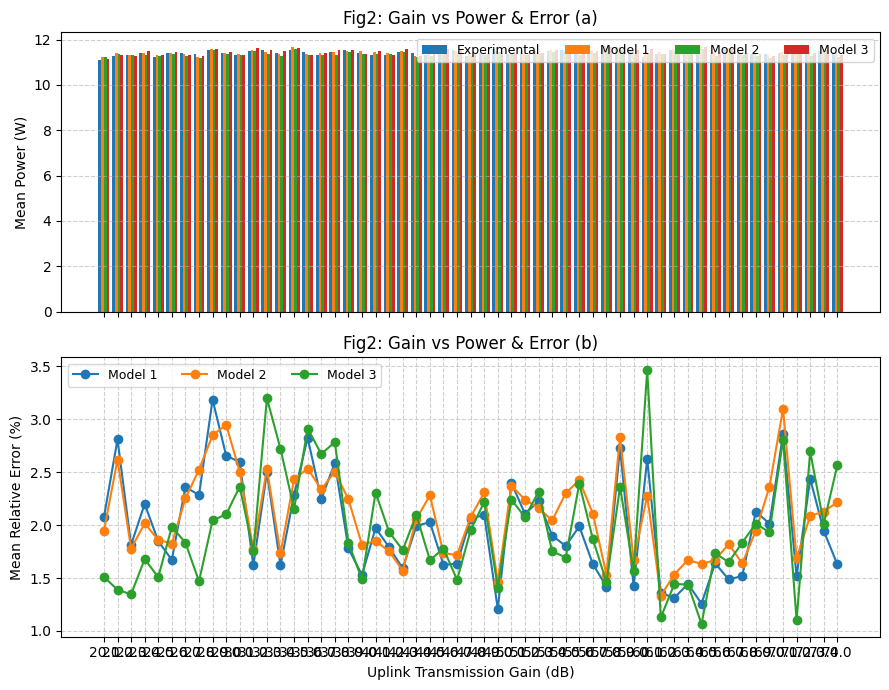

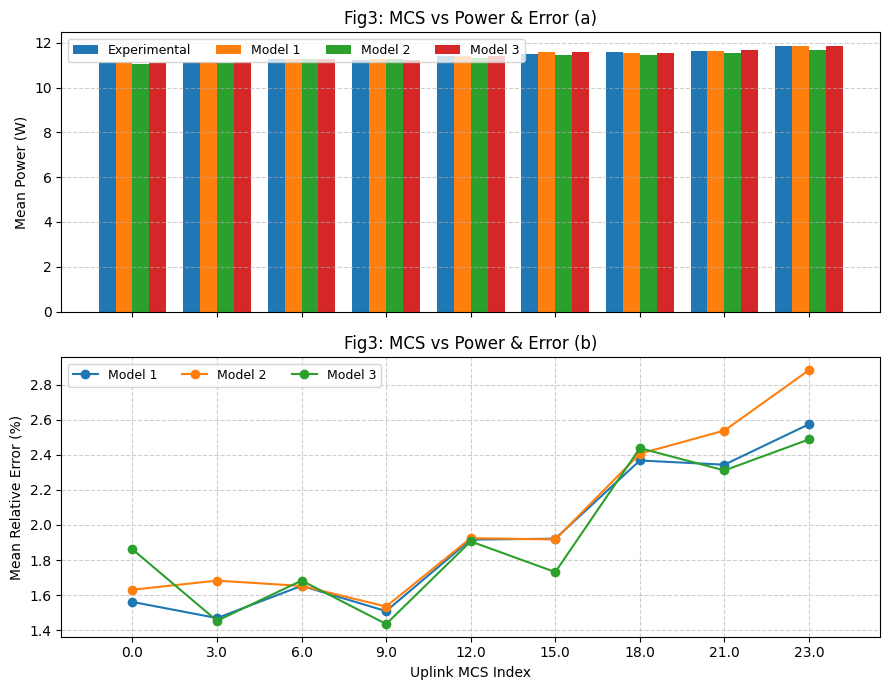

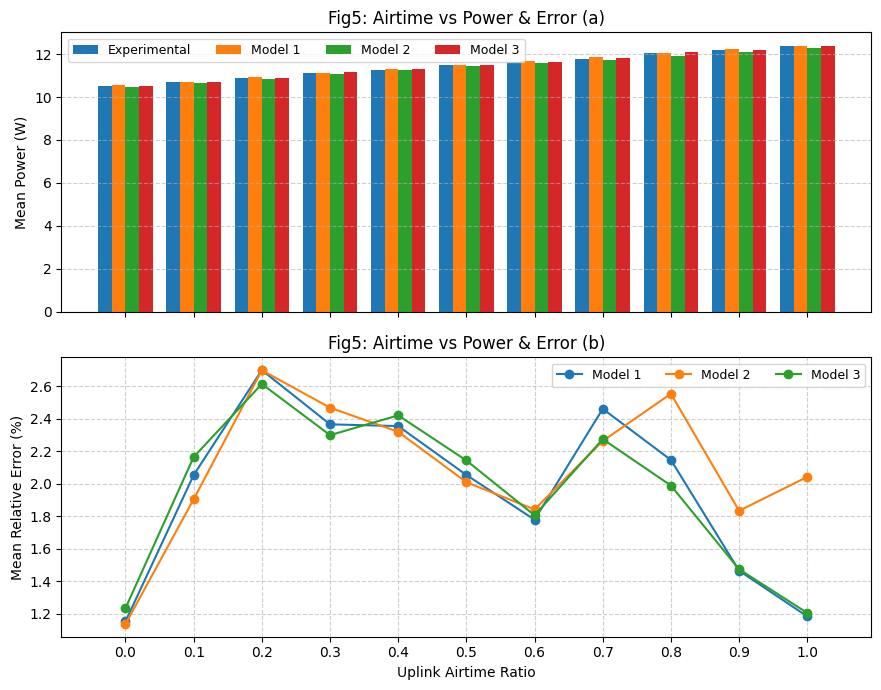

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) Build df_test (test set + preds)
# =========================
df_test = pd.DataFrame(X_test, columns=feature_cols)   # feature_cols should include: ["airtime","selected_mcs","txgain"]
df_test["pm_power_true"] = y_true_ul
df_test["pred_m1"] = m1_pred_ul
df_test["pred_m2"] = m2_pred_ul
df_test["pred_m3"] = m3_pred_ul


# =========================
# 1) Group metrics (mean power + MRE%)
# =========================
def group_mean_and_mre(df, group_col, true_col="pm_power_true", pred_cols=None, eps=1e-9):
    if pred_cols is None:
        pred_cols = ["pred_m1", "pred_m2", "pred_m3"]

    rows = []
    for g, sub in df.groupby(group_col):
        y = sub[true_col].to_numpy(dtype=float)

        row = {group_col: g}
        row["true_mean"] = float(np.mean(y))

        for pc in pred_cols:
            yhat = sub[pc].to_numpy(dtype=float)
            row[f"{pc}_mean"] = float(np.mean(yhat))
            row[f"{pc}_mre"] = float(np.mean(np.abs(y - yhat) / (np.abs(y) + eps)) * 100)

        rows.append(row)

    out = pd.DataFrame(rows).sort_values(group_col).reset_index(drop=True)
    return out


# =========================
# 2) Plot (a) grouped bars + (b) MRE line
# =========================
def plot_fig_like_camready(df_g, xcol, xlabel, title_prefix=None, rotate_xticks=0):
    """
    df_g: output of group_mean_and_mre
    xcol: grouping column name (e.g., "txgain")
    """
    # Ensure x sorted nicely
    # (If x values are numeric strings, convert to numeric for plotting order)
    xvals = df_g[xcol].to_numpy()
    try:
        x_order = np.argsort(xvals.astype(float))
        df_g = df_g.iloc[x_order].reset_index(drop=True)
        xvals = df_g[xcol].to_numpy()
    except Exception:
        pass

    x = np.arange(len(xvals))
    width = 0.2

    fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

    # ---- (a) Mean Power: grouped bar chart ----
    ax = axes[0]
    ax.bar(x - 1.5*width, df_g["true_mean"],   width, label="Experimental")
    ax.bar(x - 0.5*width, df_g["pred_m1_mean"], width, label="Model 1")
    ax.bar(x + 0.5*width, df_g["pred_m2_mean"], width, label="Model 2")
    ax.bar(x + 1.5*width, df_g["pred_m3_mean"], width, label="Model 3")

    ax.set_ylabel("Mean Power (W)")
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(ncol=4, fontsize=9)

    if title_prefix:
        ax.set_title(f"{title_prefix} (a)")

    # ---- (b) MRE: line plot ----
    ax2 = axes[1]
    ax2.plot(x, df_g["pred_m1_mre"], marker="o", label="Model 1")
    ax2.plot(x, df_g["pred_m2_mre"], marker="o", label="Model 2")
    ax2.plot(x, df_g["pred_m3_mre"], marker="o", label="Model 3")

    ax2.set_ylabel("Mean Relative Error (%)")
    ax2.set_xlabel(xlabel)
    ax2.grid(True, linestyle="--", alpha=0.6)
    ax2.legend(ncol=3, fontsize=9)

    if title_prefix:
        ax2.set_title(f"{title_prefix} (b)")

    # X ticks
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(xvals, rotation=rotate_xticks)

    plt.tight_layout()
    plt.show()


# =========================
# 3) Fig2: txgain
# =========================
df_gain = group_mean_and_mre(df_test, group_col="txgain")
plot_fig_like_camready(
    df_gain,
    xcol="txgain",
    xlabel="Uplink Transmission Gain (dB)",
    title_prefix="Fig2: Gain vs Power & Error",
    rotate_xticks=0
)


# =========================
# 4) Fig3: selected_mcs
# =========================
df_mcs = group_mean_and_mre(df_test, group_col="selected_mcs")
plot_fig_like_camready(
    df_mcs,
    xcol="selected_mcs",
    xlabel="Uplink MCS Index",
    title_prefix="Fig3: MCS vs Power & Error",
    rotate_xticks=0
)


# =========================
# 5) Fig5: airtime
#    If airtime is continuous, bin/round it first for stable bars like paper
# =========================
df_test_air = df_test.copy()

# If your airtime is already rounded, keep it; otherwise round to 1 decimal
# (This matches the [0, 0.2, 0.4, ...] style)
df_test_air["airtime_bin"] = pd.to_numeric(df_test_air["airtime"], errors="coerce").round(1)

df_air = group_mean_and_mre(df_test_air.dropna(subset=["airtime_bin"]), group_col="airtime_bin")
plot_fig_like_camready(
    df_air,
    xcol="airtime_bin",
    xlabel="Uplink Airtime Ratio",
    title_prefix="Fig5: Airtime vs Power & Error",
    rotate_xticks=0
)
